In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import timm
from IPython.display import Image
from fastai.vision.all import *
from tqdm import tqdm

In [43]:
# fastai:
# git clone https://github.com/fastai/fastai
# pip install -e "fastai[dev]"

# Introduction

Today we will take about a highly cited paper ArcFace that can help with our task

https://arxiv.org/pdf/1801.07698.pdf

## Question:

Can you tell the difference between softmax and arcface?

Hint: Look at intra and inter class coverage between (a) and (b) taken from ArcFace paper figure 3


![Arcface](img.png)

# Math of angle between vectors
$ \vec{ab}
= |a| * |b| * cos\theta$

In [15]:
a = torch.randn(1,512)
a.shape

torch.Size([1, 512])

In [16]:
a @ a.T

tensor([[491.4076]])

This is the distance between a and a itself since we know $ \theta $ must be equal to 0.

Let's make them easier for neural network to understand since NN prefer everything is normalized

In [17]:
F.normalize(a) @ F.normalize(a).T

tensor([[1.0000]])

Now it is even between for us to understand. The angle between a and a transpose is 1 (obviously :) )

Now assume we have another vector $\vec{b}$ and $\vec{c}$

In [25]:
b = torch.randn(1, 512)
c = torch.randn(1,512)
b.shape, c.shape

(torch.Size([1, 512]), torch.Size([1, 512]))

## can you identify which one is closer to a?

In [21]:
F.normalize(a) @ F.normalize(b).T

tensor([[0.0246]])

In [26]:
F.normalize(a) @ F.normalize(c).T

tensor([[0.0107]])

So we can tell that $\vec{c}$ is closer to $\vec{a}$ as its $cos\theta$ is closer to 0

Now the question becomes if I have 3 images, image_1, image_2, image_3, how can I know their feature vector $\vec{a},  \vec{b}, \vec{c}$

As you probably guessed, a CNN model encoder is perfectly for such task.

However, with 1 draw back that the CNN encoder we pretrained with softmax will give a large inter class(between two classes) coverage, which is hard for us to distingush large dataset. We will prefer if the encoder is able to push class to the edges. This is exactly the motivation behind this highly cited Arcface paper

## Arcface easy version
We are gonna implement a poorman's version of the arcface algorithm and leave you to implement your own arcface (or read their github implementation :) )

![algorithm](arcface.png)

In [34]:
emb_size = 5
output_classes = 10
batch_size = 1
fc_layer = nn.Linear(emb_size, output_classes, bias=False)

In [35]:
W = fc_layer.weight
W, W.shape

(Parameter containing:
 tensor([[-0.1937,  0.1982,  0.1916,  0.0682,  0.0041],
         [-0.1845,  0.2536, -0.3387,  0.3527,  0.1751],
         [ 0.3909, -0.1764, -0.1977,  0.3752, -0.0648],
         [-0.0655, -0.4410, -0.1715,  0.2604, -0.0233],
         [-0.0063, -0.1041, -0.2695,  0.2622,  0.2203],
         [-0.0847,  0.3643, -0.3280,  0.1280, -0.0459],
         [-0.3702,  0.1310, -0.3669, -0.0894,  0.1181],
         [ 0.2669, -0.1985, -0.3537,  0.1074, -0.3598],
         [-0.0219,  0.3522, -0.4139,  0.4017, -0.4396],
         [-0.3691,  0.3068,  0.2050, -0.2917, -0.4334]], requires_grad=True),
 torch.Size([10, 5]))

In [38]:
W = W.T
x = torch.randn(batch_size, emb_size)
W.shape, x.shape

(torch.Size([5, 10]), torch.Size([1, 5]))

## Step 1-3

In [39]:
x = F.normalize(x)
W = F.normalize(W, dim=0)
outp = x @ W
outp

tensor([[ 0.1138, -0.8699, -0.1783, -0.0222, -0.6420, -0.8873, -0.7474, -0.1987,
         -0.6000,  0.2136]], grad_fn=<MmBackward0>)

In [53]:
x[0] @ W[:,4]

tensor(-0.6420, grad_fn=<DotBackward0>)

In [55]:
F.cosine_similarity(x[0], W[:,4], dim=0)

tensor(-0.6420, grad_fn=<DivBackward0>)

## Step 4-6

Please note here the following operation should be based on target, here just for a demosntration purpose

In [56]:
ang_outp = outp.arccos()
ang_outp

tensor([[1.4567, 2.6258, 1.7500, 1.5930, 2.2678, 2.6623, 2.4150, 1.7708, 2.2144,
         1.3556]], grad_fn=<AcosBackward0>)

For machine it can just pass on, but we are human, so lets take a look of the angle

In [58]:
ang_outp[0].rad2deg()

tensor([ 83.4628, 150.4464, 100.2693,  91.2694, 129.9375, 152.5405, 138.3687,
        101.4584, 126.8734,  77.6674], grad_fn=<Rad2DegBackward0>)

Note here the smaller angle close to zero will have a $cos\theta$ close to 1 which has higher actiation when we pass it into CrossEntropy loss

The m here is a hyper parameter in their paper which you need to tune

In [60]:
m = torch.tensor(0.3)
m.rad2deg()

tensor(17.1887)

In [65]:
torch.tensor(0.4).rad2deg(), torch.tensor(0.5).rad2deg()

(tensor(22.9183), tensor(28.6479))

In [66]:
ang_outp + m

tensor([[1.7567, 2.9258, 2.0500, 1.8930, 2.5678, 2.9623, 2.7150, 2.0708, 2.5144,
         1.6556]], grad_fn=<AddBackward0>)

In [68]:
(ang_outp + m).rad2deg()

tensor([[100.6515, 167.6351, 117.4580, 108.4582, 147.1262, 169.7292, 155.5574,
         118.6471, 144.0622,  94.8562]], grad_fn=<Rad2DegBackward0>)

## Easy Implementation

In [6]:
class ArcFaceClassifier(nn.Module):
    '''
        Modified implementation from https://www.kaggle.com/slawekbiel/arcface-explained
    '''
    def __init__(self, emb_size, outp_feats, s=50., m=0.3):
        super().__init__()
        self.s = s
        self.m = m
        self.W = nn.Parameter(torch.Tensor(emb_size, outp_feats))
        nn.init.xavier_uniform_(self.W)
    def forward(self, x):
        # Step 1-2:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 3:
        return x_norm @ W_norm
    
def arcface_loss(cosine, targ, outp_cls=10, s=50., m=0.3):
    # Stablize the code
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    # Step 4-9:
    arcosine = cosine.arccos()
    arcosine = TensorBase(arcosine)
    arcosine += F.one_hot(targ, num_classes = outp_cls) * m
    outp = arcosine.cos()
    return F.cross_entropy(TensorBase(outp), TensorBase(targ))

In [4]:
class SimpleConv(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        ch_in=[3,6,12,24]
        convs = [ConvLayer(c, c*2, stride=2) for c in ch_in]
        convs += [AdaptiveAvgPool(), Flatten(), nn.Linear(48, 3)]
        self.convs = nn.Sequential(*convs)
        self.classifier = classifier
        
    def get_embs(self, x):
        return self.convs(x)
    
    def forward(self, x):
        x = self.get_embs(x)
        x = self.classifier(x)
        return x

In [5]:
dls =ImageDataLoaders.from_folder(untar_data(URLs.MNIST), train='training', valid='testing', num_workers=8)

In [7]:
learn = Learner(dls, SimpleConv(ArcFaceClassifier(3,10)), metrics=accuracy, loss_func = arcface_loss)

In [8]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.617718,1.594822,0.928600,00:22
1,1.564906,1.555252,0.961100,00:22
2,1.544299,1.537950,0.968700,00:21
3,1.532691,1.532016,0.966300,00:21
4,1.527883,1.529378,0.968000,00:21


In [9]:
# helper method to extract all embedings from a data loader
# Implementation from https://www.kaggle.com/slawekbiel/arcface-explained
def get_embs(model, dl):
    embs = []
    ys = []
    for bx,by in tqdm(dl):
        with torch.no_grad():
            embs.append(model.get_embs(bx))
            ys.append(by)
    embs = torch.cat(embs)
    embs = embs / embs.norm(p=2,dim=1)[:,None]
    ys = torch.cat(ys)
    return embs,ys

# helper to plot embeddings in 3D
def plot_embs(embs, ys, ax):
    #ax.axis('off')
    for k in range(10):
        e = embs[ys==k].cpu()
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2)

In [10]:
embs_arcface, ys_arcface  = get_embs(learn.model.eval(), dls.valid)

100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 96.80it/s]


In [11]:
learn = Learner(dls, SimpleConv(ArcFaceClassifier(3,10)), metrics=accuracy)

In [12]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.547802,1.530410,0.907600,00:21
1,1.509678,1.502636,0.952700,00:23
2,1.492554,1.492779,0.968700,00:22
3,1.483983,1.484568,0.977600,00:23
4,1.480700,1.482731,0.979000,00:22


In [13]:
embs_softmax, ys_softmax  = get_embs(learn.model.eval(), dls.valid)

100%|█████████████████████████████████████████| 157/157 [00:01<00:00, 78.58it/s]


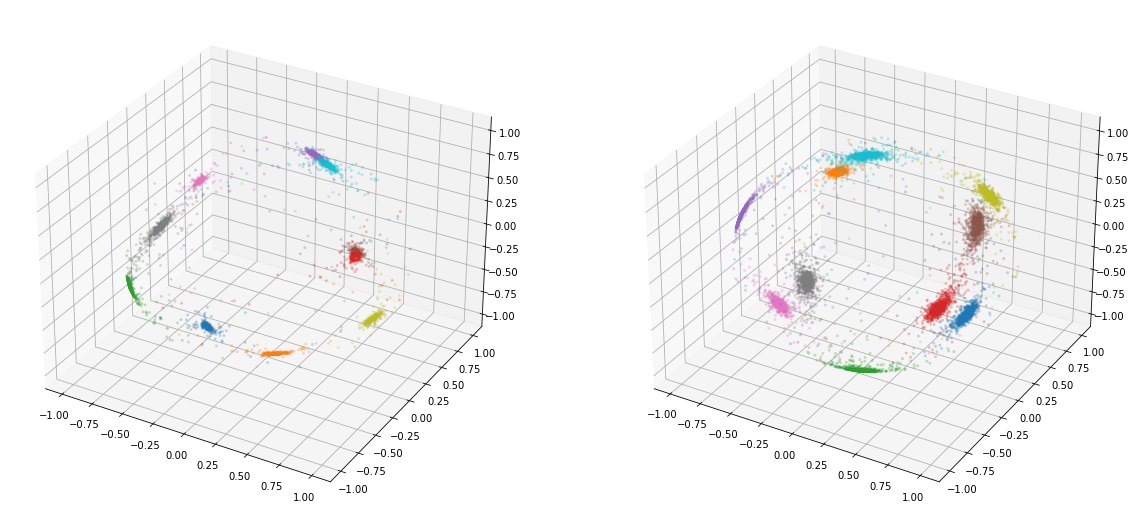

In [14]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)
plot_embs(embs_softmax, ys_softmax, ax2)

plt.show()

# Fin

Result too good

In [16]:
# Result too good

class Arcface(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        self.backbone = timm.create_model('resnet18',pretrained=True,num_classes=0)
        self.feat = nn.Linear(512,3,bias=False)
        self.classifier = classifier
        
    def get_embs(self, x):
        bs = x.shape[0]
        return self.feat(self.backbone(x).view(bs, -1))
    
    def forward(self, x):
        x = self.get_embs(x)
        x = self.classifier(x)
        return x

In [17]:
learn = Learner(dls, Arcface(ArcFaceClassifier(3,10)), metrics=accuracy, loss_func = arcface_loss)

In [18]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.591635,1.616997,0.890500,00:44
1,1.548548,1.570186,0.934900,00:43
2,1.531467,1.518014,0.985500,00:40
3,1.518052,1.510324,0.991500,00:38
4,1.513649,1.509155,0.993000,00:37


In [19]:
embs_arcface, ys_arcface  = get_embs(learn.model.eval(), dls.valid)

100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 70.21it/s]


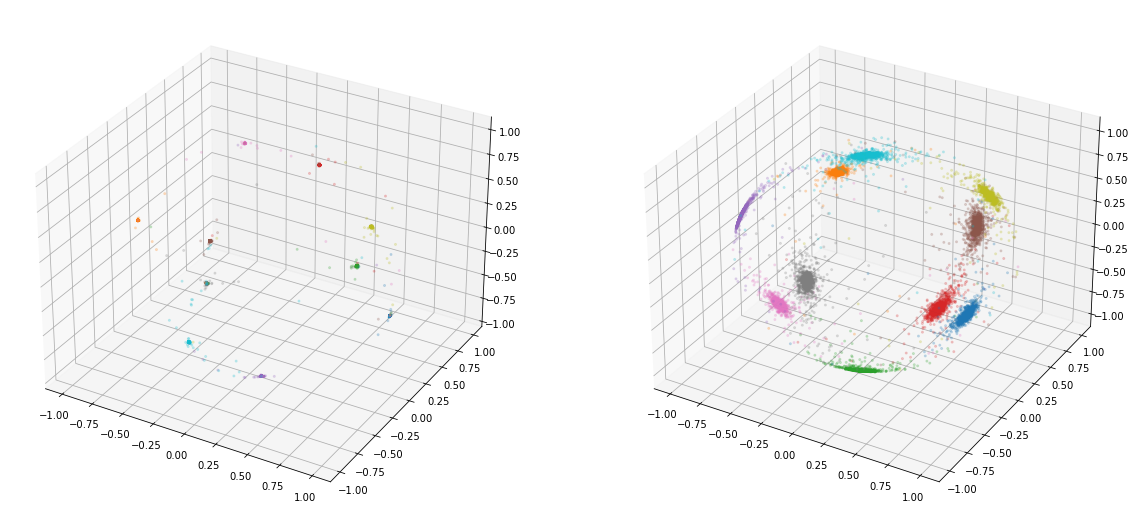

In [20]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)
plot_embs(embs_softmax, ys_softmax, ax2)

plt.show()

In [21]:
learn = Learner(dls, Arcface(ArcFaceClassifier(3,10)), metrics=accuracy)

In [22]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.512783,1.490420,0.963100,00:37
1,1.491847,1.540018,0.905800,00:37
2,1.480012,1.475561,0.985900,00:38
3,1.472427,1.471306,0.992000,00:40
4,1.469261,1.469543,0.992700,00:40


In [23]:
embs_softmax, ys_softmax  = get_embs(learn.model.eval(), dls.valid)

100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 63.71it/s]


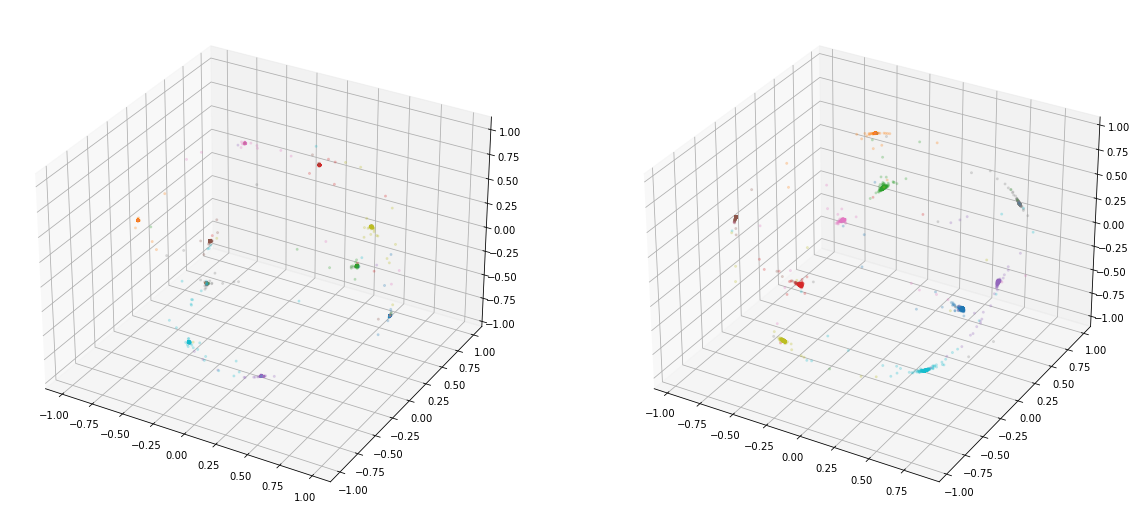

In [24]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)
plot_embs(embs_softmax, ys_softmax, ax2)

plt.show()